## Zillow Data Analysis

In this notebook, let us try and explore the data given for Zillow prize competition. Before we dive deep into the data, let us know a little more about the objective.

### Zillow:

Zillow is an online real estate database company founded in 2006 - Wikipedia

### Zestimate:

“Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today)

### Objective

Building a model to improve the Zestimate residual error.

**logerror=log(Zestimate)−log(SalePrice)**

**Predict 6 time points for all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).**


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import missingno as msno
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
warnings.filterwarnings('ignore')


color = sns.color_palette()

%matplotlib inline

In [58]:
#Load Properties_2016 File, Train Data File
prop_df = pd.read_csv("/Users/sbendrala/SpringBoard_Projects/Capstone Projects/Data/properties_2016.csv")
train_df=pd.read_csv('/Users/sbendrala/SpringBoard_Projects/Capstone Projects/Data/train_2016_v2.csv', parse_dates=["transactiondate"])

In [47]:
print(prop_df.head())
print(train_df.head())

   parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
0  10754147                    NaN                       NaN           NaN   
1  10759547                    NaN                       NaN           NaN   
2  10843547                    NaN                       NaN           NaN   
3  10859147                    NaN                       NaN           NaN   
4  10879947                    NaN                       NaN           NaN   

   bathroomcnt  bedroomcnt  buildingclasstypeid  buildingqualitytypeid  \
0          0.0         0.0                  NaN                    NaN   
1          0.0         0.0                  NaN                    NaN   
2          0.0         0.0                  NaN                    NaN   
3          0.0         0.0                  3.0                    7.0   
4          0.0         0.0                  4.0                    NaN   

   calculatedbathnbr  decktypeid         ...           numberofstories  \
0           

In [59]:
#Check the Decoration of prop_df
prop_df.columns

Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

In [48]:
#Train DF 
train_df['logerror'].describe()

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64

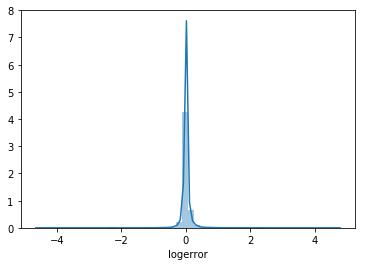

In [6]:
#histogram
sns.distplot(train_df['logerror']);

### Shape of the Data Set

In [7]:
#Shape of Train and Prop Data
print('Shape of Properties Data Set: ', prop_df.shape)
print('Shape of Train Data Set: ', train_df.shape)

Shape of Properties Data Set:  (2985217, 58)
Shape of Train Data Set:  (90275, 3)


### Merge Data Set

In [60]:
merge_df=pd.merge(train_df,prop_df,how='left',on='parcelid')

### View Merged Data


In [50]:
merge_df.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


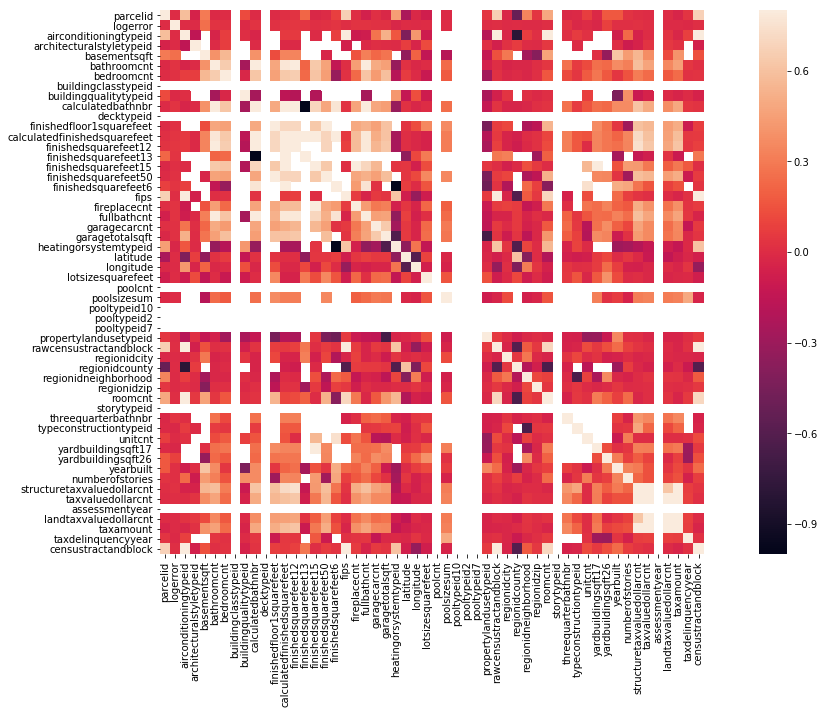

In [10]:
corrmat=merge_df.corr()
f,ax=plt.subplots(figsize=(20, 10))
sns.heatmap(corrmat,vmax=0.8,square=True)

### Visualize Data Types

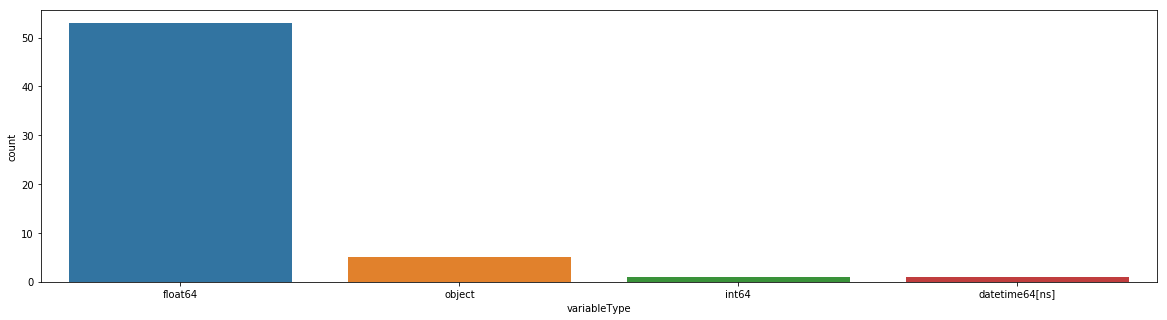

In [11]:
dataType=pd.DataFrame(merge_df.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax=plt.subplots()
fig.set_size_inches(20,5)
sns.barplot(data=dataType,x='variableType',y='count')

### Missing Value Analysis

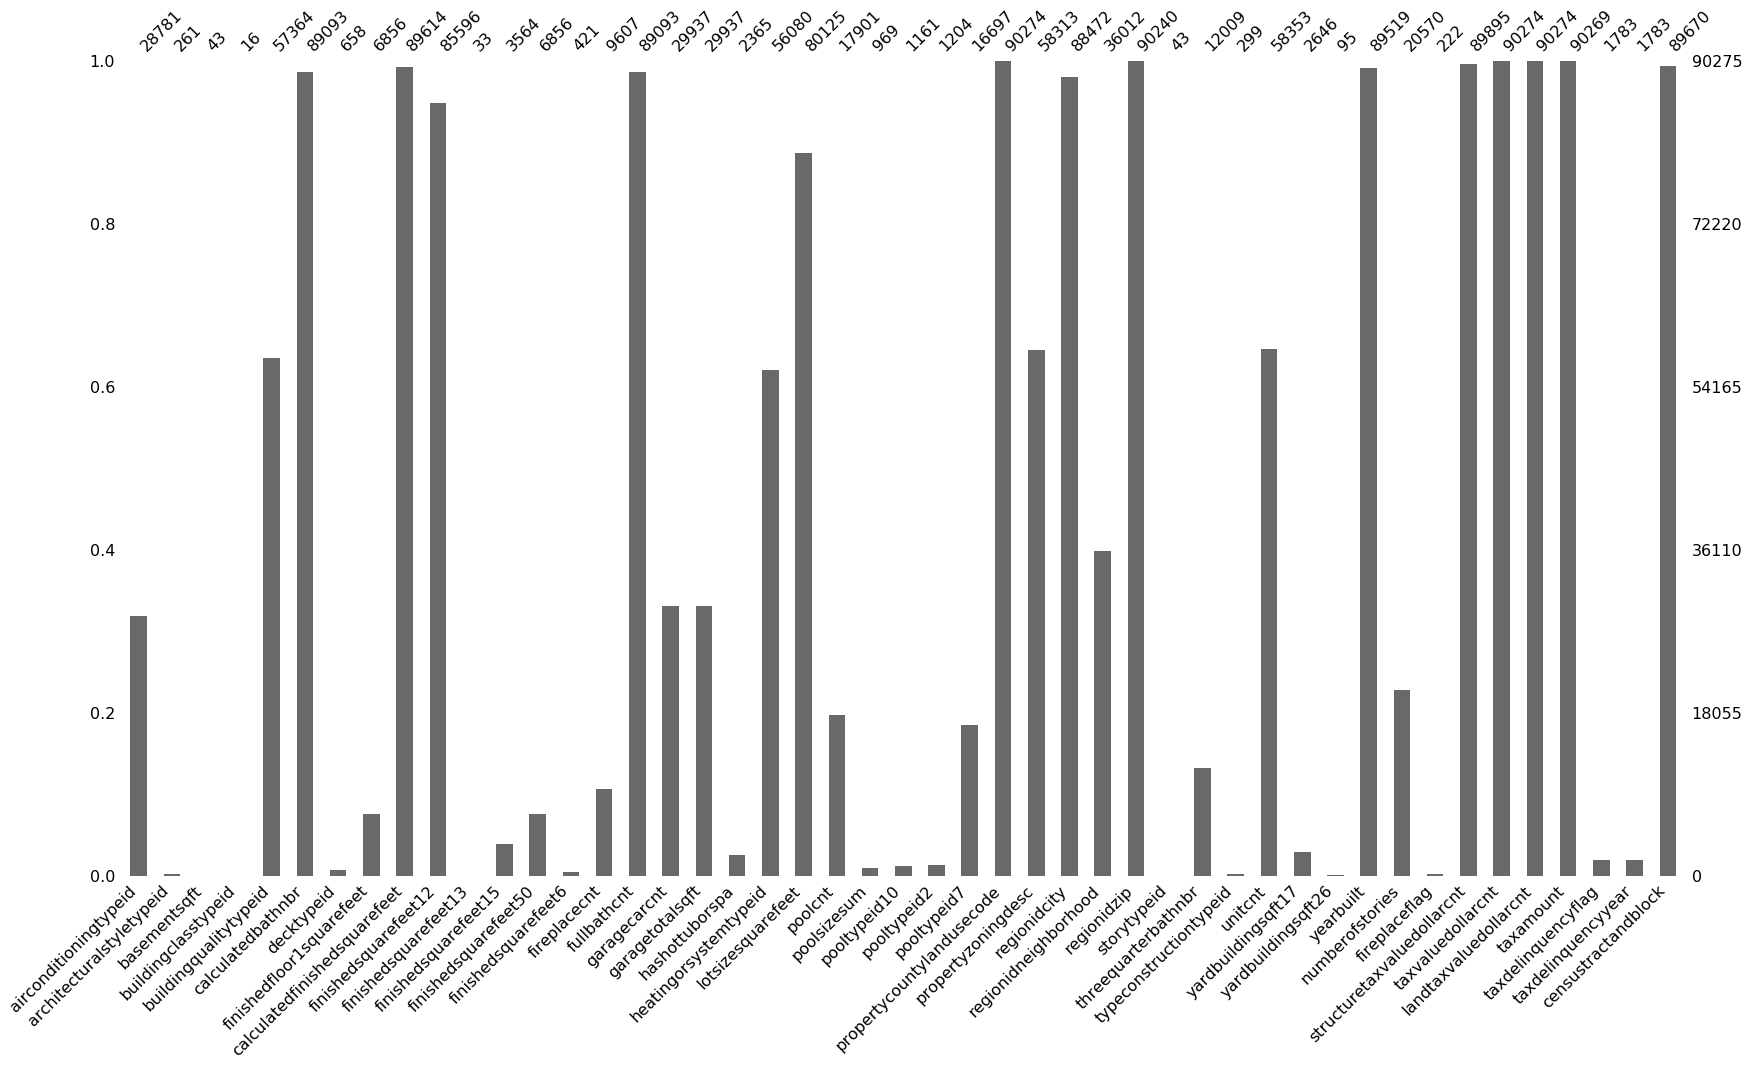

In [12]:
mergedColumns=merge_df.columns[merge_df.isnull().any()].tolist()
msno.bar(merge_df[mergedColumns],labels=True,figsize=(28, 15))

## UniVariate Analysis

In [13]:
mean_values=merge_df.mean()
train_df_new=merge_df.fillna(mean_values)

In [14]:
x_cols = [col for col in train_df_new.columns if col not in ['logerror'] if train_df_new[col].dtype=='float64']

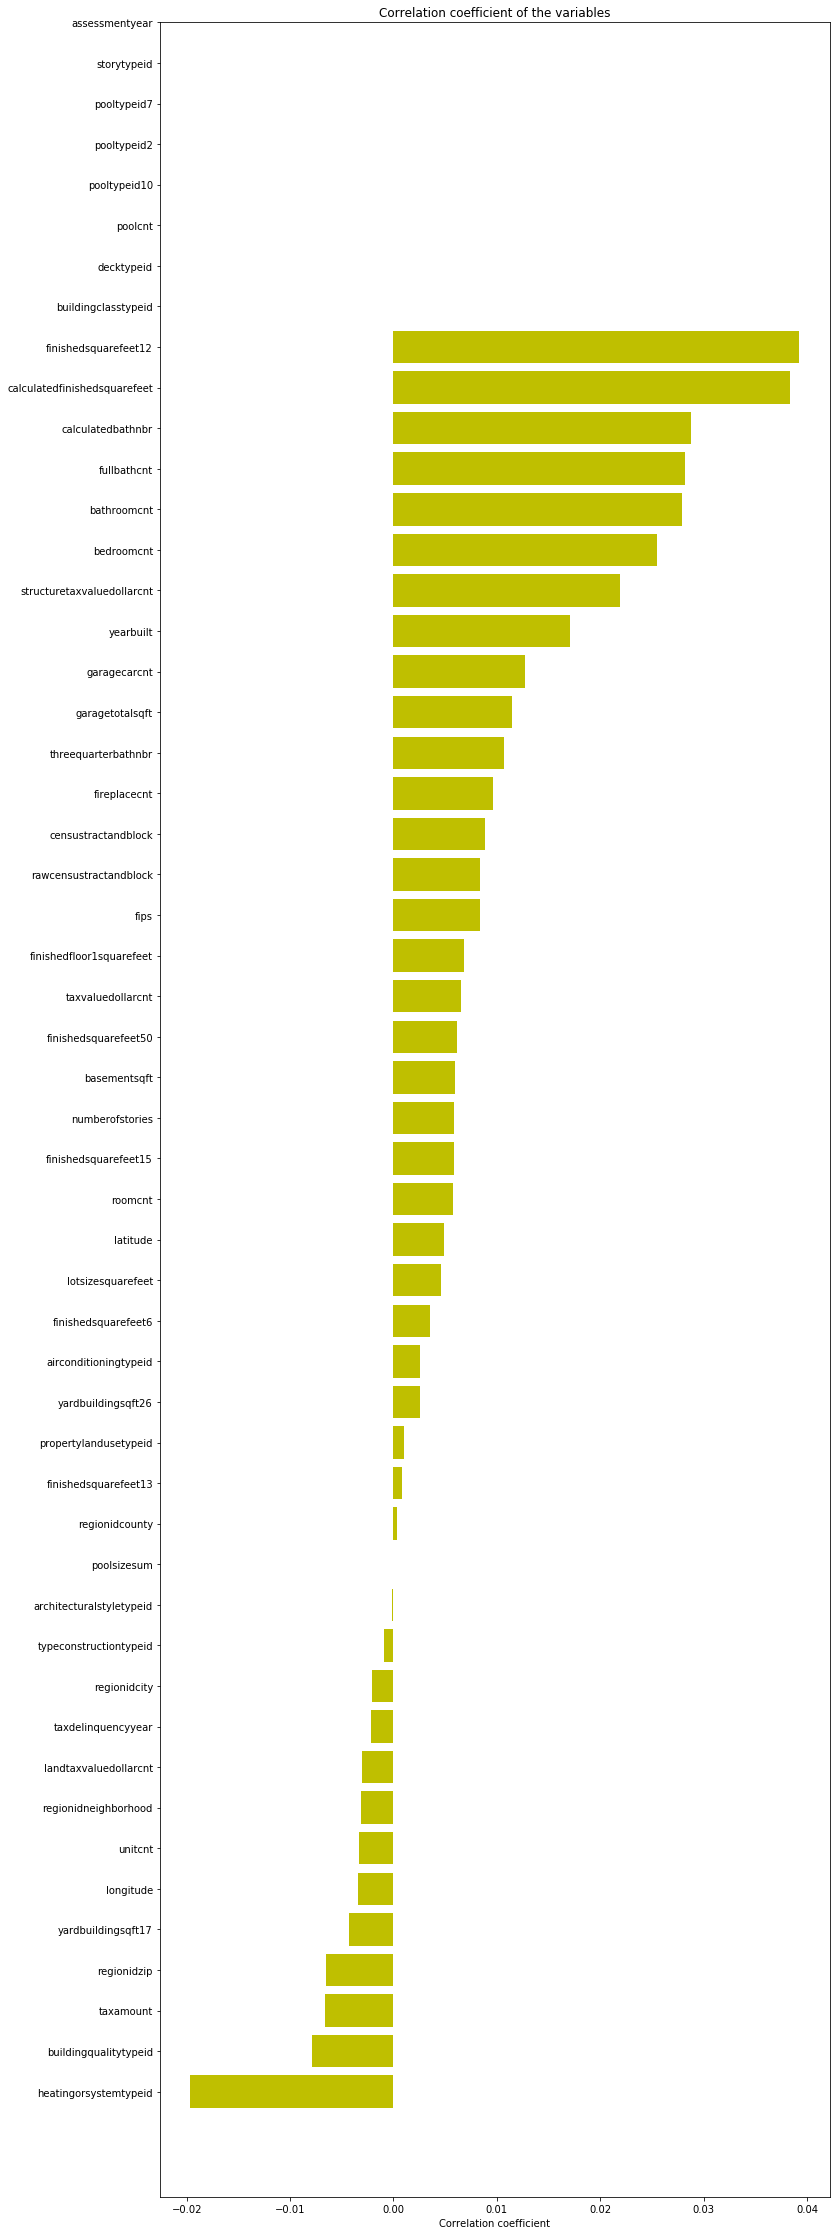

In [24]:
labels=[]
values=[]

for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_new[col].values,train_df_new.logerror.values)[0,1])
corr_df=pd.DataFrame({'col_labels':labels,'corr_value':values})
corr_df=corr_df.sort_values(by='corr_value')

ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_value.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

**The correlation of the target variable with the given set of variables are low overal**

## Filter Features based on the Correlation Values

In [22]:
corr_df_sel = corr_df.loc[(corr_df['corr_value']>0.02) | (corr_df['corr_value'] < -0.01)]
corr_df_sel

,col_labels,corr_value
21,heatingorsystemtypeid,-0.019648
45,structuretaxvaluedollarcnt,0.021935
4,bedroomcnt,0.025467
3,bathroomcnt,0.027889
18,fullbathcnt,0.028169
7,calculatedbathnbr,0.028758
10,calculatedfinishedsquarefeet,0.038341
11,finishedsquarefeet12,0.039248


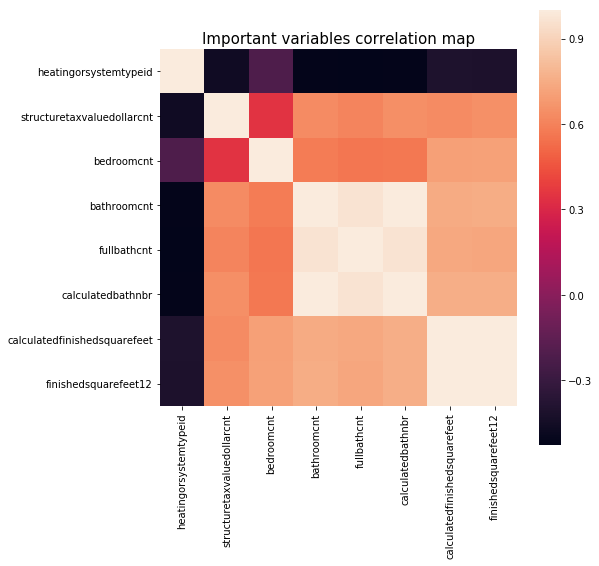

In [26]:
cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = merge_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

In [33]:
merge_df['finishedsquarefeet12'].values

array([1684., 2263., 2217., ...,   nan, 1034., 1524.])

## Individual Feature Analysis

**finishedsquarefeet12**

<Figure size 864x864 with 0 Axes>

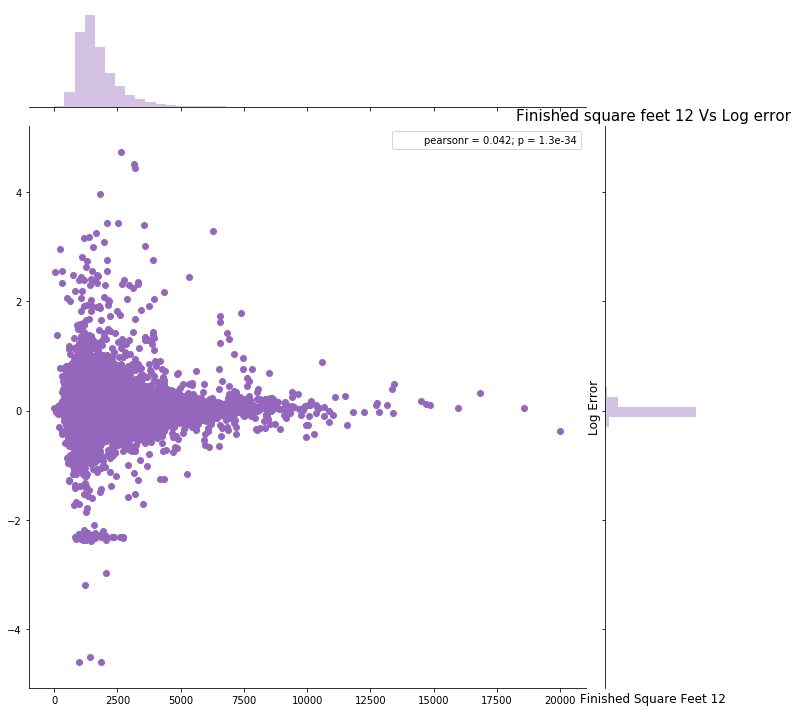

In [39]:
col='finishedsquarefeet12'

ulimit=np.percentile(merge_df[col].values,99.5)
llimit=np.percentile(merge_df[col].values,0.5)

merge_df[col].loc[merge_df[col]>ulimit] = ulimit
merge_df[col].loc[merge_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=merge_df.finishedsquarefeet12.values, y=merge_df.logerror.values, size=10, color=color[4])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

In [51]:
merge_df.columns

Index(['parcelid', 'logerror', 'transactiondate', 'airconditioningtypeid',
       'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'bedroomcnt',
       'buildingclasstypeid', 'buildingqualitytypeid', 'calculatedbathnbr',
       'decktypeid', 'finishedfloor1squarefeet',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcn

**logerror narrows down with increase in finished square feet 12 variable. Probably larger houses are easy to predict?**

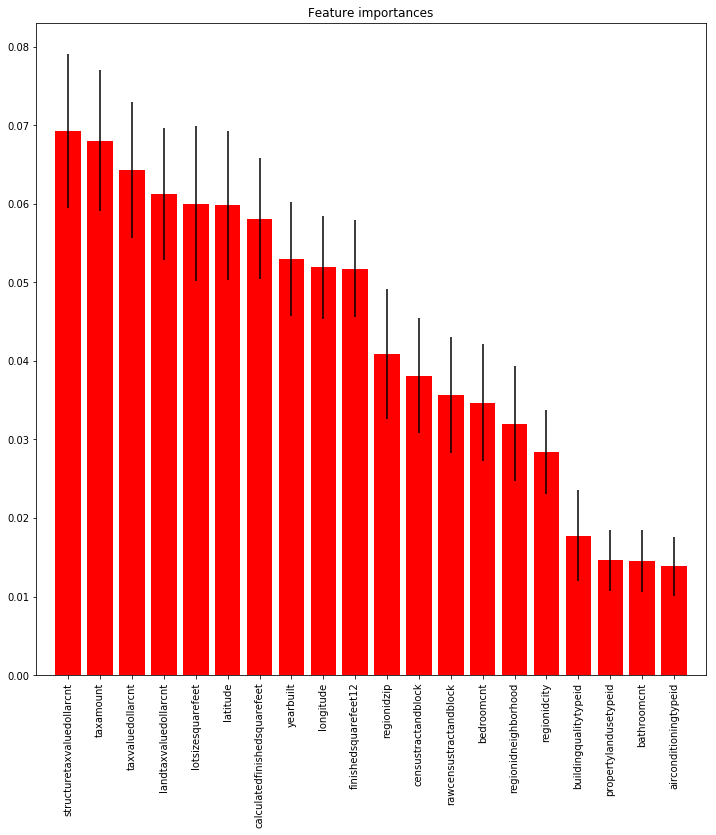

In [52]:
train_y = merge_df['logerror'].values
cat_cols = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
merge_df = merge_df.drop(['parcelid', 'logerror', 'transactiondate']+cat_cols, axis=1)
train_df=merge_df.fillna(mean_values)
feat_names = train_df.columns.values

from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_df, train_y)

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
0,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,NaN,NaN,...,NaN,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,6.037107e+13
1,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,...,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN
2,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,NaN,NaN,...,NaN,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,6.037464e+13
3,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,NaN,NaN,...,NaN,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,6.037296e+13
4,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,NaN,...,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,6.059042e+13


**Seems "structure tax value dollar count"is the most importanct variable followed by "tax amount" and "tax value dollor count"**

In [62]:
from sklearn import model_selection, preprocessing
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

mergedFilterd = merge_df.fillna(mean_values)
for f in mergedFilterd.columns:
    if mergedFilterd[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(mergedFilterd[f].values)) 
        mergedFilterd[f] = lbl.transform(list(mergedFilterd[f].values))
train_y = mergedFilterd.logerror.values
train_X = mergedFilterd.drop(["parcelid", "transactiondate", "logerror"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

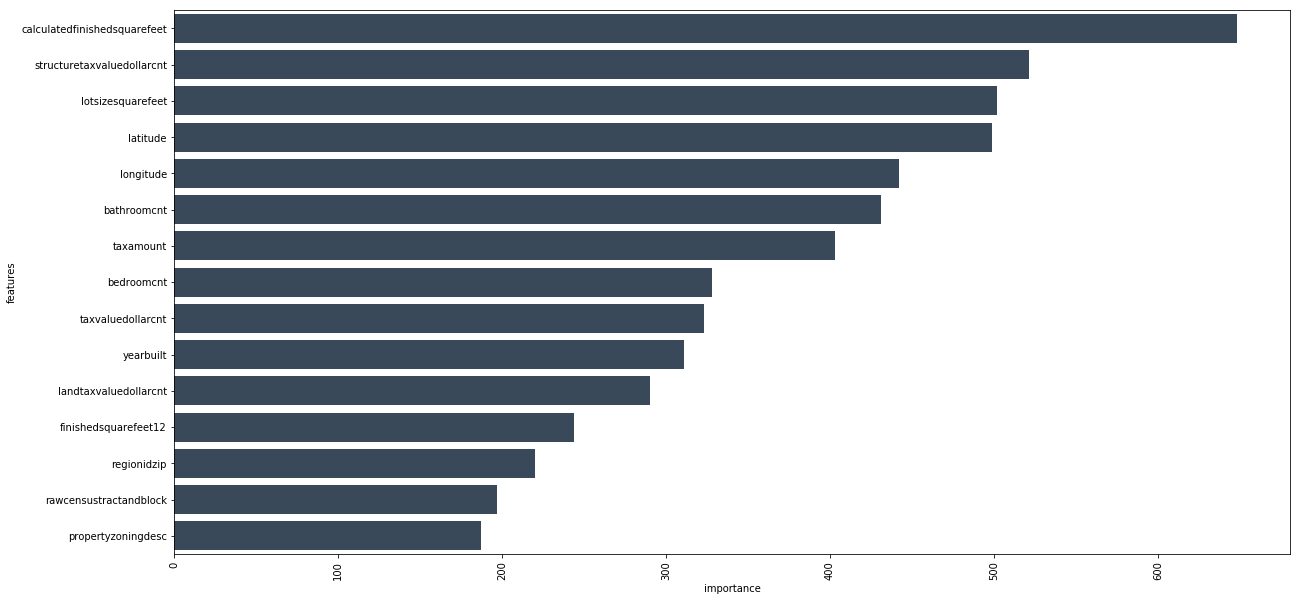

In [64]:
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sns.barplot(data=features.head(15),x="importance",y="features",ax=ax,orient="h",color="#34495e")